In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import uuid

f:\a02_env_ware\ana\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# 日线数据 - 用于生成交易信号
df_daily = pd.read_csv('BTC_USDT_1day_2021.1.1-2021.12.31一年数据.csv')

# 分钟线数据 - 用于精确判断卖出
df_minute = pd.read_csv('BTC_USDT_30min_2021.1.1-2021.12.31一年数据.csv')

# 给分钟数据添加日期列（用于分组）
df_minute['date'] = pd.to_datetime(df_minute['datatime'], unit='ms').dt.date
df_daily['date'] = pd.to_datetime(df_daily['datatime'], unit='ms').dt.date

In [3]:
# 测试不同k值对夏普比的影响

import numpy as np

# 创建k值列表
k_values = np.arange(0, 1.02, 0.02)  # 从0到1，步长0.02

# 存储结果
results = []

# 循环测试每个k值
for k1 in k_values:
    print(f'正在测试 k1 = {k1:.2f}...')
    
    # 重置参数
    ori_capital = 100000.0
    capital = ori_capital
    in_ratio = 0.03
    commission_rate = 0.001
    stop_loss_rate = 0.5
    stop_make_rate = 0.5
    all_trades = []
    
    # 回测循环（和你原来的代码一样）
    for i in range(len(df_daily)):
        if i < 1:
            continue

        data_today = df_daily.iloc[i]
        data_prev = df_daily.iloc[i-1]
        today_date = data_today['date']

        prev_up = data_prev['close'] > data_prev['open']
        pre_range = (data_prev['high'] - data_prev['low']) / data_prev['open']

        if prev_up:
            predict_price = data_today['open'] * (1 - k1 * pre_range)
            if predict_price < data_today['open']:
                direction = -1
        else:
            predict_price = data_today['open'] * (1 + k1 * pre_range)
            if predict_price > data_today['open']:
                direction = 1

                in_price = data_today['open']
                in_money = capital * in_ratio
                buy_commission = in_money * commission_rate
                buy_amount = (in_money - buy_commission)/in_price

                capital = capital - in_money

                in_time = data_today['datatime']
                in_time_readable = datetime.fromtimestamp(in_time/ 1000)

                if direction == -1:
                    stop_loss_price = in_price * (1 + stop_loss_rate)
                    stop_make_price = in_price * (1 - stop_make_rate)
                elif direction == 1:
                    stop_loss_price = in_price * (1 - stop_loss_rate)
                    stop_make_price = in_price * (1 + stop_make_rate)

                today_minutes = df_minute[df_minute['date'] == today_date].copy()
                out_price = None
                out_time = None

                for idx,minute_data in today_minutes.iterrows():
                    if minute_data['high'] >= min(predict_price,stop_make_price):
                        out_price = min(predict_price,stop_make_price)
                        out_time = minute_data['datatime']
                        break
                    elif minute_data['low'] <= stop_loss_price:
                        out_price = stop_loss_price
                        out_time = minute_data['datatime']
                        break

                if out_price is None:
                    out_price = today_minutes.iloc[-1]['close']
                    out_time = today_minutes.iloc[-1]['datatime']
                out_time_readable = datetime.fromtimestamp(out_time / 1000)

                sell_money = out_price * buy_amount
                sell_commission = sell_money * commission_rate
                out_money = sell_money - sell_commission

                capital = capital + out_money

                trade = {
                    'uuid': str(uuid.uuid4()),
                    'symbol': 'BTC_USDT',
                    'in_price': in_price,
                    'out_price': out_price,
                    'stop_loss_price': stop_loss_price,
                    'stop_make_price': stop_make_price,
                    'commission_rate': commission_rate,
                    'commission': 0.0,
                    'profit': out_money-in_money,
                    'quantity': buy_amount,
                    'in_time': in_time_readable,
                    'out_time': out_time_readable,
                    'direction': direction,
                }

                all_trades.append(trade)

    # 计算本次回测的指标
    if len(all_trades) > 0:
        trades_df_temp = pd.DataFrame(all_trades)
        
        # 计算夏普比
        returns = trades_df_temp['profit'] / (trades_df_temp['in_price'] * trades_df_temp['quantity'])
        mean_return = returns.mean()
        std_return = returns.std()
        
        if std_return > 0:
            sharpe_yearly = (mean_return / std_return) * np.sqrt(365)
        else:
            sharpe_yearly = 0
        
        # 计算其他指标
        trade_count = len(trades_df_temp)
        win_count = len(trades_df_temp[trades_df_temp['profit'] > 0])
        win_rate = win_count / trade_count * 100 if trade_count > 0 else 0
        
        # 计算最大回撤
        pnl = trades_df_temp['profit'].cumsum()
        capital_curve = pnl + ori_capital
        rolling_max = capital_curve.expanding().max()
        drawdown = (rolling_max - capital_curve) / rolling_max
        max_drawdown = drawdown.max()
        
        # 计算总收益
        total_profit = trades_df_temp['profit'].sum()
        total_return = total_profit / ori_capital * 100
        
    else:
        sharpe_yearly = 0
        trade_count = 0
        win_rate = 0
        max_drawdown = 0
        total_profit = 0
        total_return = 0
    
    # 记录结果
    results.append({
        'k值': k1,
        '夏普比率': sharpe_yearly,
        '交易次数': trade_count,
        '胜率(%)': win_rate,
        '最大回撤(%)': max_drawdown * 100,
        '总收益': total_profit,
        '总收益率(%)': total_return
    })

# 转换为DataFrame
results_df = pd.DataFrame(results)
print('\n' + '='*80)
print('测试完成！')
print('='*80)
results_df

正在测试 k1 = 0.00...
正在测试 k1 = 0.02...
正在测试 k1 = 0.04...
正在测试 k1 = 0.06...
正在测试 k1 = 0.08...
正在测试 k1 = 0.10...
正在测试 k1 = 0.12...
正在测试 k1 = 0.14...
正在测试 k1 = 0.16...
正在测试 k1 = 0.18...
正在测试 k1 = 0.20...
正在测试 k1 = 0.22...
正在测试 k1 = 0.24...
正在测试 k1 = 0.26...
正在测试 k1 = 0.28...
正在测试 k1 = 0.30...
正在测试 k1 = 0.32...
正在测试 k1 = 0.34...
正在测试 k1 = 0.36...
正在测试 k1 = 0.38...
正在测试 k1 = 0.40...
正在测试 k1 = 0.42...
正在测试 k1 = 0.44...
正在测试 k1 = 0.46...
正在测试 k1 = 0.48...
正在测试 k1 = 0.50...
正在测试 k1 = 0.52...
正在测试 k1 = 0.54...
正在测试 k1 = 0.56...
正在测试 k1 = 0.58...
正在测试 k1 = 0.60...
正在测试 k1 = 0.62...
正在测试 k1 = 0.64...
正在测试 k1 = 0.66...
正在测试 k1 = 0.68...
正在测试 k1 = 0.70...
正在测试 k1 = 0.72...
正在测试 k1 = 0.74...
正在测试 k1 = 0.76...
正在测试 k1 = 0.78...
正在测试 k1 = 0.80...
正在测试 k1 = 0.82...
正在测试 k1 = 0.84...
正在测试 k1 = 0.86...
正在测试 k1 = 0.88...
正在测试 k1 = 0.90...
正在测试 k1 = 0.92...
正在测试 k1 = 0.94...
正在测试 k1 = 0.96...
正在测试 k1 = 0.98...
正在测试 k1 = 1.00...

测试完成！


,k值,夏普比率,交易次数,胜率(%),最大回撤(%),总收益,总收益率(%)
0,0.00,0.000000,0,0.000000,0.000000,0.000000,0.000000
1,0.02,-4.307151,180,15.555556,1.406416,-1402.542580,-1.402543
2,0.04,-2.122376,180,61.111111,0.729972,-713.228768,-0.713229
3,0.06,-2.478279,180,79.444444,1.309471,-1272.662513,-1.272663
4,0.08,-1.923509,180,87.777778,1.146785,-1089.717857,-1.089718
5,0.10,-0.855266,180,88.888889,0.799370,-499.248352,-0.499248
6,0.12,-0.223255,180,89.444444,0.595772,-141.237038,-0.141237
7,0.14,0.247495,180,87.777778,0.647287,155.797798,0.155798
8,0.16,0.243174,180,84.444444,0.714619,159.902979,0.159903
9,0.18,0.395963,180,83.333333,0.609598,275.575413,0.275575


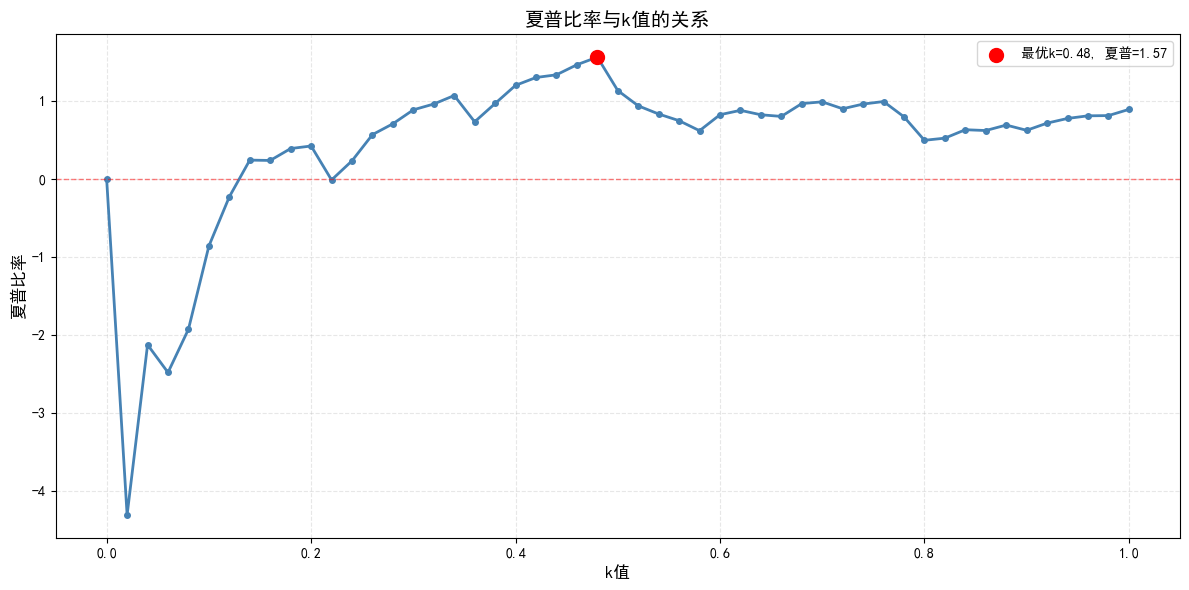


最佳k值：0.48
对应夏普比率：1.57


In [4]:
# 绘制夏普比率与k值的关系图
import matplotlib.pyplot as plt

# 设置中文字体显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(12, 6))
plt.plot(results_df['k值'], results_df['夏普比率'], marker='o', linewidth=2, markersize=4, color='steelblue')
plt.title('夏普比率与k值的关系', fontsize=14, fontweight='bold')
plt.xlabel('k值', fontsize=12)
plt.ylabel('夏普比率', fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.5, linewidth=1)

# 标注最大值点
max_idx = results_df['夏普比率'].idxmax()
max_k = results_df.loc[max_idx, 'k值']
max_sharpe = results_df.loc[max_idx, '夏普比率']
plt.scatter([max_k], [max_sharpe], color='red', s=100, zorder=5, label=f'最优k={max_k:.2f}, 夏普={max_sharpe:.2f}')

plt.legend(fontsize=10)
plt.tight_layout()
plt.show()

# 输出最佳k值信息
print(f"\n{'='*50}")
print(f"最佳k值：{max_k:.2f}")
print(f"对应夏普比率：{max_sharpe:.2f}")
print(f"{'='*50}")